# SuperflexPy example 01: Run a simple model and analyze the results

Author: Marco Dal Molin

Collaborators: Fabrizio Fenicia, Dmitri Kavetski

## What's in this example

This example will cover the following aspects:

- [Assign input to an existing model](https://superflexpy.readthedocs.io/en/latest/components.html#inputs-and-outputs-formats)
- [Run the model and check the outputs](https://superflexpy.readthedocs.io/en/latest/demo.html#lumped-model-structure)
- [Inspect internal fluxes and states](https://superflexpy.readthedocs.io/en/latest/demo.html#lumped-model-structure)
- [Check and update states and parameters](https://superflexpy.readthedocs.io/en/latest/components.html#generalities)

By clicking on the items you will be redirected to the documentation page (when available) that explains the arguments in a more detailed way. 

## What's not in this example

The following aspects are already covered in other examples:

- [Initialize already implemented elements](./03_init_single_element_model.ipynb)
- [Put elements together to initialize a Unit](./04_init_single_unit_model.ipynb)

For this reason we will put only the code need, without further explanations. You can check the other examples by clicking on the items above.

## Do you want to use this example as a script?

Examples of SuperflexPy are created and distributed using Jupyter notebooks because they enable to conjugate runnable code with text explanations. We have decided to not provide the content of the notebooks as script because this would mean duplicating the same content in multiple places, bringing to maintainability problems.

If the user wants to download the content of this notebook as a python script, it is possible following the steps:
1. If not already done, open this notebook using [Binder](https://mybinder.org/v2/gh/dalmo1991/superflexPy/master?filepath=examples%2F01_run_simple_model.ipynb)
2. Go on File -> Download as -> Python (.py)
3. Select the saving path

The result is a Python script that contains all the markdown text as comment and the code contained inside the cells.

## STEP 0: Import of external libraries

The execution of the code in this example relies on the following external libraries:
- **numpy**: arrays handling
- **matplotlib**: visualization

We assume that those libraries are already installed, together with the latest version of SuperflexPy. Keep in mind that not all the libraries listed above are strictly needed to execute SuperflexPy and, therefore, they are not listed as requirements of SuperflexPy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## STEP 1: Initialize the model

In this example we will use the Unit as maximum complexity level of the model. The same operations illustrated in this example can be done similarly with any SuperflexPy component (i.e. Element, Unit, Node, Network).

The model is imported and initialized in the following cell.

In [2]:
from superflexpy.implementation.computation.pegasus_root_finding import PegasusPython
from superflexpy.implementation.computation.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.elements.hbv import FastReservoir
from superflexpy.framework.unit import Unit

# Initialize numercal routines
root_finder = PegasusPython()
numeric_approximator = ImplicitEulerPython(root_finder=root_finder)

# Initialize the elements
fr_1 = FastReservoir(
    parameters={'k': 0.1, 'alpha': 1.0},
    states={'S0': 10.0},
    approximation=numeric_approximator,
    id='FR-1'
)

fr_2 = FastReservoir(
    parameters={'k': 0.01, 'alpha': 2.0},
    states={'S0': 1.0},
    approximation=numeric_approximator,
    id='FR-2'
)

# Initialize the Unit
model = Unit(
    layers=[
        [fr_1],
        [fr_2]
    ],
    id='model'
)

## STEP 2: Run the model

### 01. Generate/Read the inputs

For this simple example, the only input needed is the precipitation array, which is generated randomly. Evapotranspiration is not considered.

In [3]:
# Fix the seed
SEED = 2
rng = np.random.RandomState(seed=SEED)

P = np.zeros(100)
P[:10] = rng.randint(10, size=10)
P[25:30] = rng.randint(20, size=5)
P[40:60] = rng.randint(5, size=20)
P[80:83] = rng.randint(30, 50, size=3)

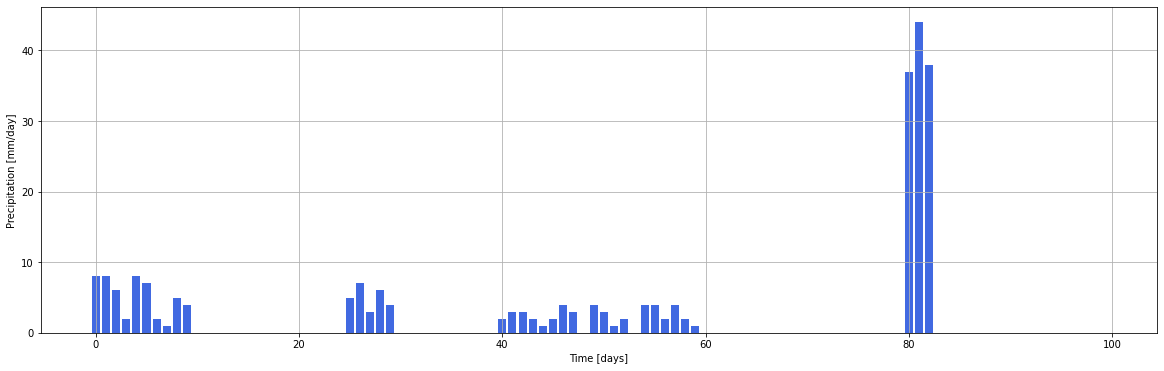

In [4]:
# Plot

fig1, ax1 = plt.subplots(1, 1, figsize=(20, 6))
ax1.bar(x=np.arange(len(P)), height=P, color='royalblue')
ax1.set_xlabel('Time [days]')
ax1.set_ylabel('Precipitation [mm/day]')
ax1.grid(True)
pass

### 02. Assign the input to the model

It is sufficient to assign the input to the model (which, in this case, is a Unit). The model takes care of distributing the flux to the components contained.

In [5]:
model.set_input([P])

### 03. Set the time step

The time step used by all the components of the framework is set by the Unit to 1 (day).

In [6]:
model.set_timestep(1.0)

### 04. Run the model

Now that everything has been set, the model can run. The output of the method is the outflow of the model, which, in this case, coincides with the outflow of the downstream element.

In [7]:
output = model.get_output()

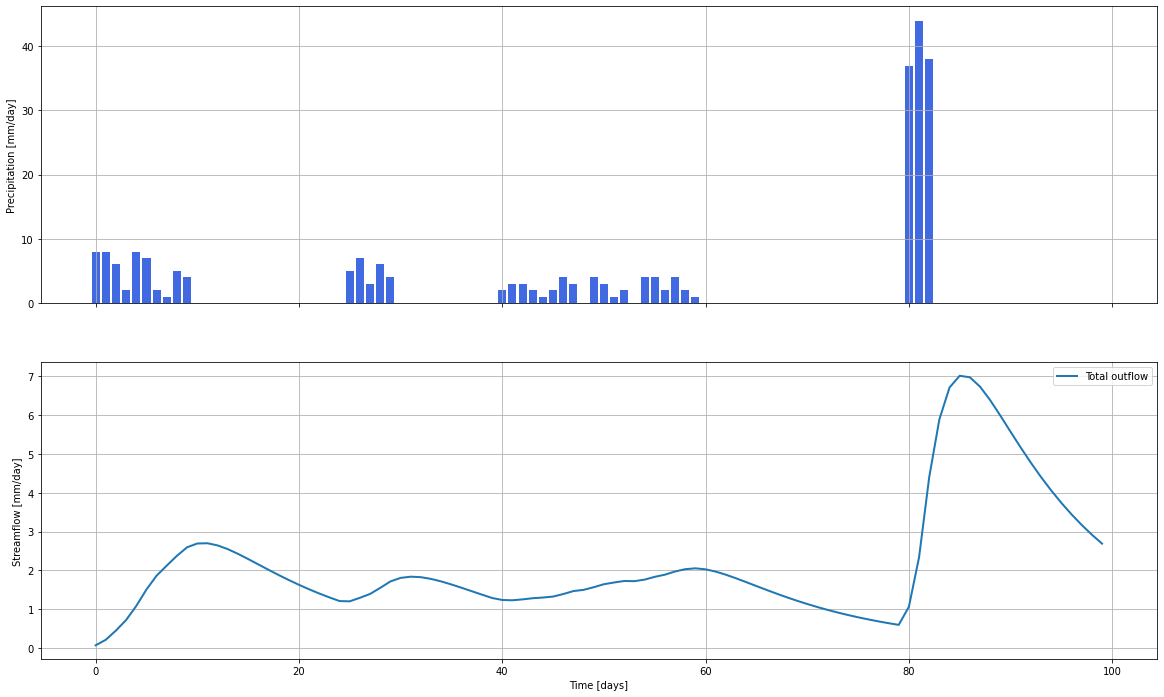

In [8]:
# Plot

fig2, ax2 = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
ax2[0].bar(x=np.arange(len(P)), height=P, color='royalblue')
ax2[0].set_ylabel('Precipitation [mm/day]')
ax2[0].grid(True)
ax2[1].plot(np.arange(len(P)), output[0], lw=2, label='Total outflow')
ax2[1].set_xlabel('Time [days]')
ax2[1].set_ylabel('Streamflow [mm/day]')
ax2[1].legend()
ax2[1].grid(True)
pass

## STEP 3: Inspect internal fluxes and states

The output returned when running the model consists only of the outflow of the downstream element. It is however of practical interest to inspect the intermediate fluxes and the states of the different elements composing the model.

### 01. Get the fluxes

The model contains 2 reservoirs. The outflow of the upstream reservoir can be obtained using the method `call_internal` of the model to run the `get_output` method of the reservoir.

In [9]:
output_upstream = model.call_internal(id='FR-1', method='get_output', solve=False)

## 02. Inspect the states

The states of the reservoirs are saved after the model run. They can be inspected using the method `get_internal` of the model to get the variable the `states_array` of the reservoirs.

In [10]:
state_upstream = model.get_internal(id='FR-1', attribute='state_array')
state_downstream = model.get_internal(id='FR-2', attribute='state_array')

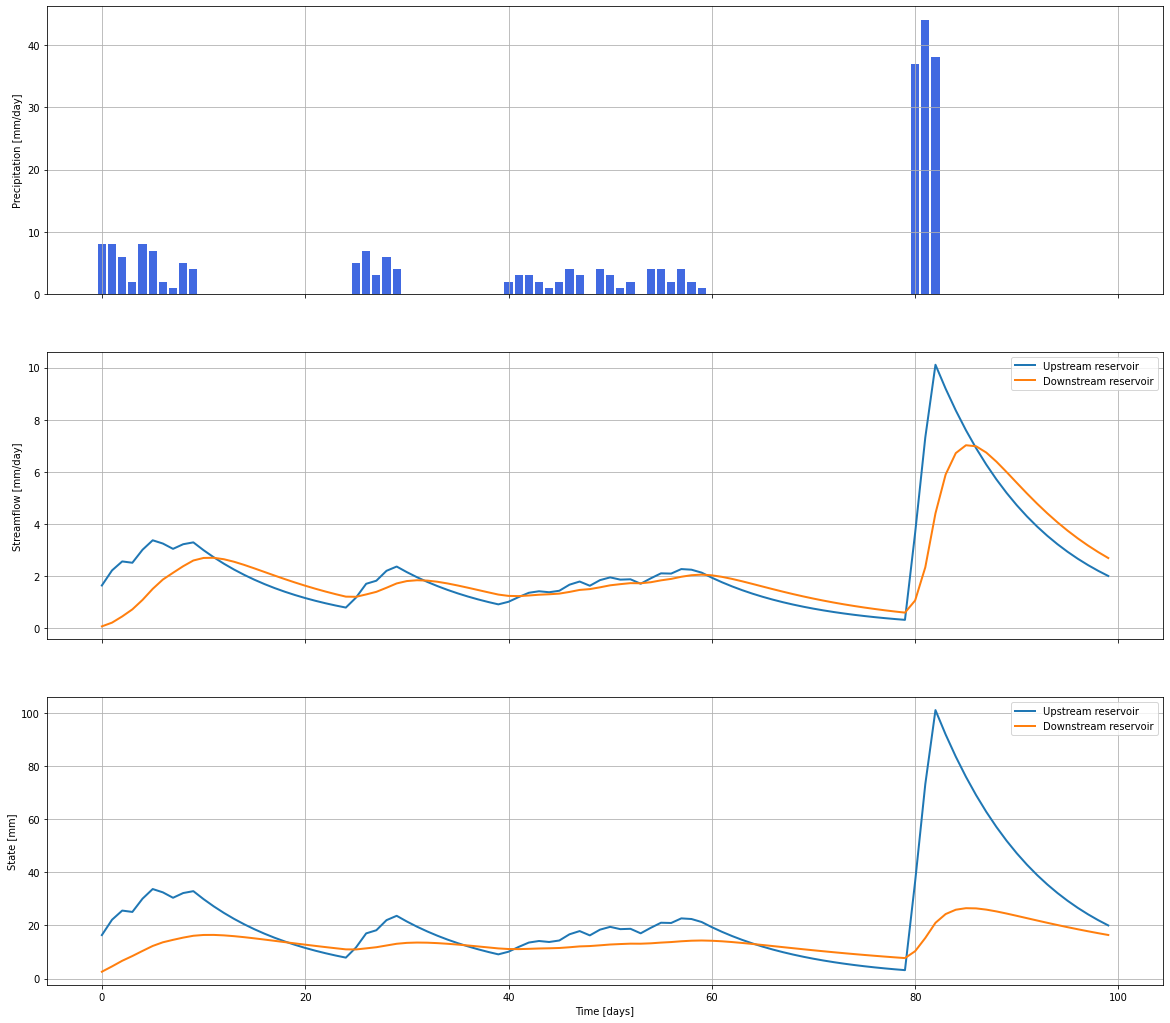

In [11]:
# Plot

fig3, ax3 = plt.subplots(3, 1, figsize=(20, 18), sharex=True)
ax3[0].bar(x=np.arange(len(P)), height=P, color='royalblue')
ax3[0].set_ylabel('Precipitation [mm/day]')
ax3[0].grid(True)
ax3[1].plot(np.arange(len(P)), output_upstream[0], lw=2, label='Upstream reservoir')
ax3[1].plot(np.arange(len(P)), output[0], lw=2, label='Downstream reservoir')
ax3[1].set_ylabel('Streamflow [mm/day]')
ax3[1].legend()
ax3[1].grid(True)
ax3[2].plot(np.arange(len(P)), state_upstream, lw=2, label='Upstream reservoir')
ax3[2].plot(np.arange(len(P)), state_downstream, lw=2, label='Downstream reservoir')
ax3[2].set_xlabel('Time [days]')
ax3[2].set_ylabel('State [mm]')
ax3[2].legend()
ax3[2].grid(True)
pass

## STEP 4: Check and update states and parameters

Components are controlled by parameters and states. These are identified by a unique identifier that can be used to set/get them. Setting and getting the parameters and states values must be done at the upper level of the framework that is used (the Unit, in this example).

### 01. Getting the identifiers

Parameters and states are identified by unique identifiers, which are needed to set or get their value. SuperflexPy implements the methods `get_parameters_name` and `get_states_name` that returns a list of the identifiers of all the available parameters and states. Note how the identifiers contain information about the component to witch their belong

In [12]:
print('Available parameters')
print(model.get_parameters_name())
print('Available states')
print(model.get_states_name())

Available parameters
['model_FR-1_k', 'model_FR-1_alpha', 'model_FR-2_k', 'model_FR-2_alpha']
Available states
['model_FR-1_S0', 'model_FR-2_S0']


### 02. Getting the values

Values of states and parameters can be obtained using the methods `get_parameters` and `get_states`. The methods take a list of identifiers as optional argument. If no list is passed, then all the parameters are returned.

In [13]:
print('Value of the parameter \"model_FR-1_alpha\"')
print(model.get_parameters(names=['model_FR-1_alpha']))
print('Value of all the parameters')
print(model.get_parameters())
print('Value of the state \"model_FR-2_S0\"')
print(model.get_states(names=['model_FR-2_S0']))
print('Value of all the states')
print(model.get_states())

Value of the parameter "model_FR-1_alpha"
{'model_FR-1_alpha': 1.0}
Value of all the parameters
{'model_FR-1_k': 0.1, 'model_FR-1_alpha': 1.0, 'model_FR-2_k': 0.01, 'model_FR-2_alpha': 2.0}
Value of the state "model_FR-2_S0"
{'model_FR-2_S0': 16.39777978634003}
Value of all the states
{'model_FR-1_S0': 19.999120153768562, 'model_FR-2_S0': 16.39777978634003}


### 03. Setting the values

Values of states and parameters can be set using the methods `set_parameters` and `set_states`. The methods take a dictionary of the format `{id: value}`.

In [14]:
print('Change the value of the parameters \"model_FR-1_k\" and \"model_FR-1_alpha\"')
model.set_parameters(parameters={'model_FR-1_k': 0.2, 'model_FR-1_alpha': 2.0})
print(model.get_parameters(names=['model_FR-1_k', 'model_FR-1_alpha']))
print('Change the value of the state \"model_FR-1_S0\"')
model.set_states(states={'model_FR-1_S0': 15.0})
print(model.get_states(names=['model_FR-1_S0']))

Change the value of the parameters "model_FR-1_k" and "model_FR-1_alpha"
{'model_FR-1_k': 0.2, 'model_FR-1_alpha': 2.0}
Change the value of the state "model_FR-1_S0"
{'model_FR-1_S0': 15.0}


### 04. Resetting the states

After the model runs, the states are modified to their value at the last time step. The method `reset_states` allows to set the states back to their initialization value. This can be useful when running the model multiple times for calibration.

In [15]:
print('States before reset')
print(model.get_states())
model.reset_states()
print('States after reset')
print(model.get_states())

States before reset
{'model_FR-1_S0': 15.0, 'model_FR-2_S0': 16.39777978634003}
States after reset
{'model_FR-1_S0': 10.0, 'model_FR-2_S0': 1.0}
